In [4]:
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import json
from os import path, scandir
sys.path.insert(1,'../')
import preprocess_wf 
from load_and_GD_funs import load_waveforms, load_timestamps, get_pdf_model,run_pdf_GD  
from wf_similarity_measures import wf_correlation, similarity_SSQ, label_from_corr
from event_rate_funs import get_ev_labels, get_event_rates, __delta_ev_measure__
from plot_functions_wf import *
from evaluation import run_DBSCAN_evaluation, run_evaluation, run_visual_evaluation



<img src="../figures/jupyter/raw_rec_to_notebook.png">

## Load and preprocess CAP-waveforms

 
 *******************************************************************************
Starting analysis on recording : R10_6.30.16_BALBC_IL1B(35ngperkg)_TNF(0.5ug)_05 


 Loading matlab waveforms files... 

waveforms loaded succesfully... 

Shape of waveforms: (140238, 143).


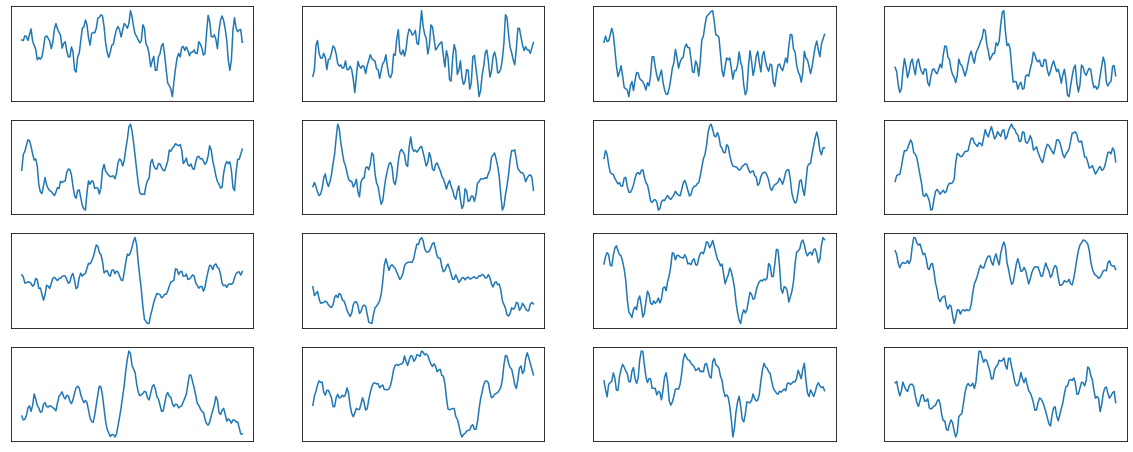

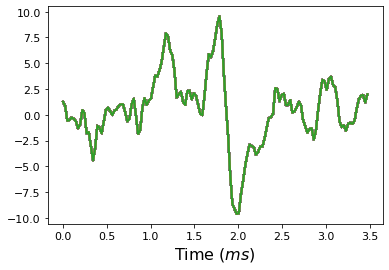


 After further thresholding, including :  
 Amplitude Thresholds (min/max) 
 event-rate threshold 



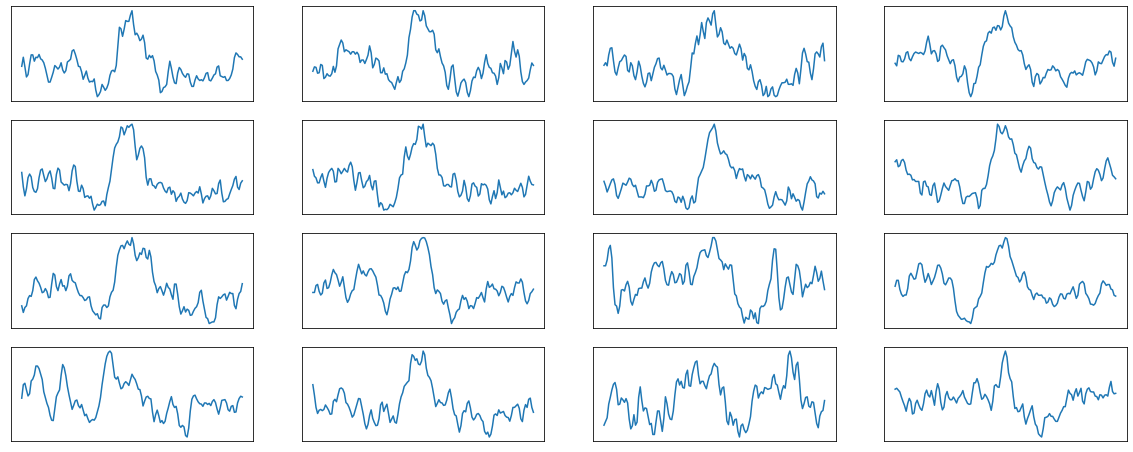

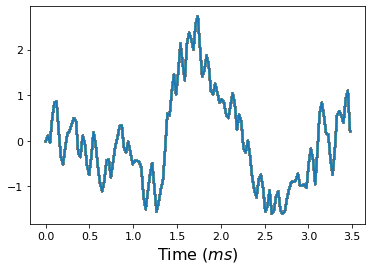

In [11]:
json_hype_file = 'finalrun'
with open('../hypes/'+json_hype_file+'.json', 'r') as f:
    hypes = json.load(f)
start_string = 'finalrun_first'
directory = '../../matlab_files'
rec_start_string = '\\tsR10_6.30.16_BALBC_IL1B(35ngperkg)_TNF(0.5ug)_05'
for entry in scandir(directory):
    if entry.path.startswith(directory+rec_start_string): # Find unique recording string. tsR10 for all cytokine injections, tsR12 for saline. 
        #matlab_file = entry.path[19:-4] # Find unique recording string'
        matlab_file = entry.path[len(directory+'\\ts'):-len('.mat')] # extract only the matlab_file name from string.
        print(' \n *******************************************************************************')
        print(f'Starting analysis on recording : {matlab_file} \n')
        
        path_to_matlab_wf = directory + '/wf'+matlab_file +'.mat' # This is how the waveforms are saved. path + wf+MATLAB_FILE_NAME.mat
        path_to_matlab_ts = directory + '/ts'+matlab_file +'.mat'
        path_to_model_weights =  '../models/'+start_string + matlab_file
        unique_string_for_run = start_string + matlab_file
        wf_0 = load_waveforms(path_to_matlab_wf,'waveforms', verbose=1)
        ts_0 = load_timestamps(path_to_matlab_ts,'timestamps',verbose=0)
        fig = plt.figure(figsize=(20, 8))
        plot_waveforms_grid(wf_0,4, saveas=None,verbose=True,title=None)
        plot_waveforms(wf_0[8,:])
        plt.show()
        waveforms,timestamps = preprocess_wf.apply_amplitude_thresh(wf_0,ts_0, hypes) # Remove "extreme-amplitude" CAPs-- otherwise risk that pdf-GD diverges..
        waveforms,timestamps = preprocess_wf.get_desired_shape(waveforms, timestamps, hypes)
        waveforms = preprocess_wf.standardise_wf(waveforms)
        wf_0 = preprocess_wf.standardise_wf(wf_0)      
        print('\n After further thresholding, including :  \n Amplitude Thresholds (min/max) \n event-rate threshold \n')
        fig = plt.figure(figsize=(20, 8))
        plot_waveforms_grid(waveforms,4, saveas=None,verbose=True,title=None)
        plt.show()
        plot_waveforms(waveforms[2,:])

## Similarity Measure

..\event_rate_funs.py:133: UserWarning: No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.
  warnings.warn('No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.')


Number of waveforms above threshold for wf_idx=10 : 50.


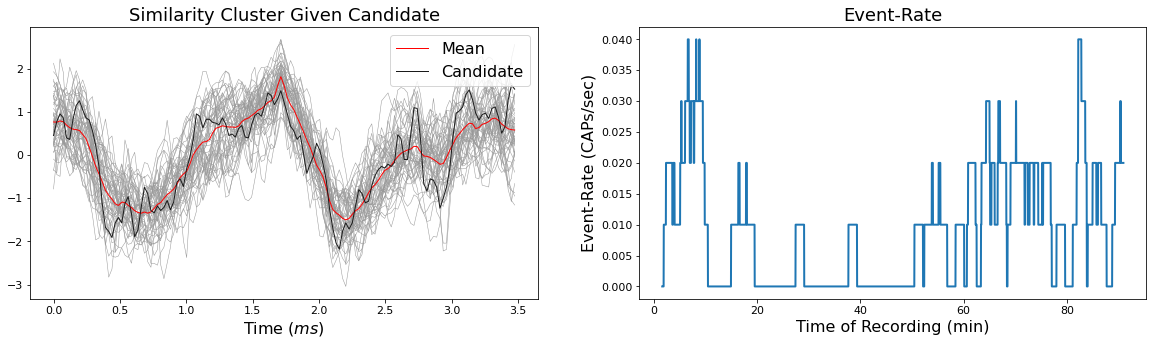

..\event_rate_funs.py:133: UserWarning: No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.
  warnings.warn('No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.')


Number of waveforms above threshold for wf_idx=40 : 309.


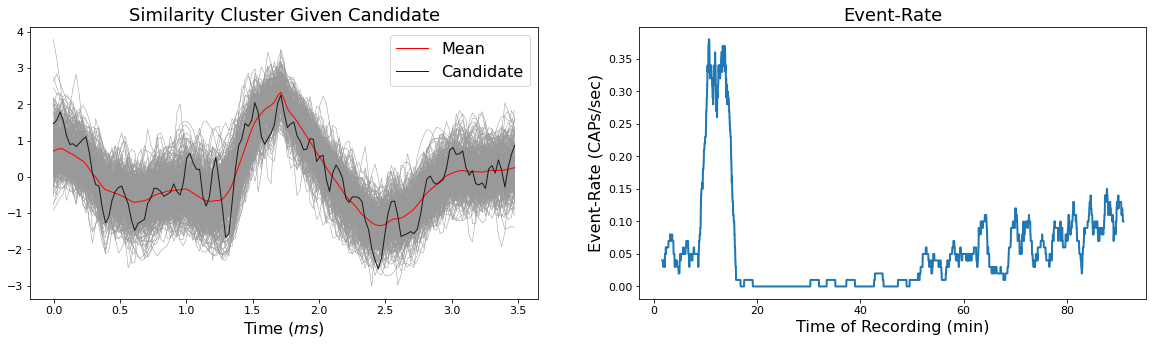

..\event_rate_funs.py:133: UserWarning: No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.
  warnings.warn('No timestamps given to "__delta_ev_measure__()". Assumes full time of recording.')


Number of waveforms above threshold for wf_idx=80 : 219.


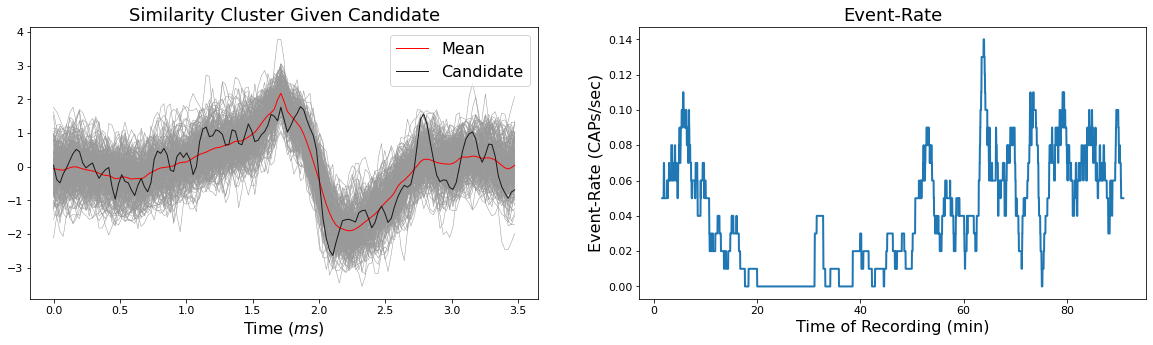

In [12]:
title_similarity = 'Similarity Cluster Given Candidate'
assumed_model_varaince = hypes["labeling"]["assumed_model_varaince"]
threshold = hypes["labeling"]["similarity_thresh"]
saveas = None
for i in [10,40,80]:
    #bool_labels,_ = similarity_SSQ(i, wf_0/assumed_model_varaince, epsilon=threshold, standardised_input=True)
    bool_labels,_ = similarity_SSQ(i, wf_0/0.7, epsilon=0.1, standardised_input=True)

    event_rates, real_clusters = get_event_rates(ts_0,bool_labels,bin_width=1,consider_only=1)
    delta_ev, ev_stats = __delta_ev_measure__(event_rates)
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plot_similar_wf(i,wf_0,bool_labels,threshold,saveas=saveas,verbose=False,title=title_similarity)
    plt.subplot(1,2,2)
    plot_event_rates(event_rates,ts_0,noise=None,conv_width=100,saveas=saveas, verbose=False) 
    plt.show()

## Load EV-labels

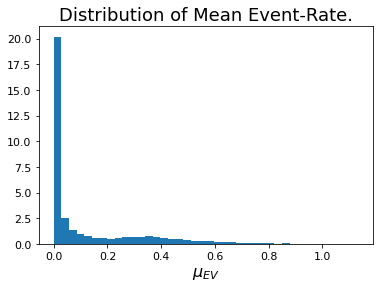

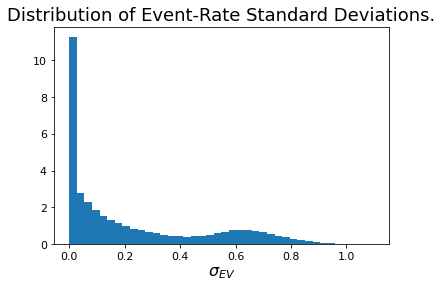

In [86]:
ev_labels = np.load(path_to_EVlabels+'.npy')
ev_stats_tot = np.load(path_to_EVlabels+'tests_tot.npy')
plot_event_rate_stats_hist(ev_stats_tot,saveas=None,verbose=True)

<img src="../figures/jupyter/TNF_cand_second_18_janR10_6_30_16_BALBC_IL1B(35ngperkg)_TNF(0_5ug)_05overall_EV.png" width="700">


## Load Probabilistic Model


In [87]:
encoder,decoder,cvae = get_pdf_model(wf_ho, nr_epochs=0, batch_size=128, path_to_weights=path_to_model_weights, 
                                                continue_train=False, verbose=1, ev_label=ev_label_ho)


Loading ../models/finalrun_firstR10_6.30.16_BALBC_IL1B(35ngperkg)_TNF(0.5ug)_05...



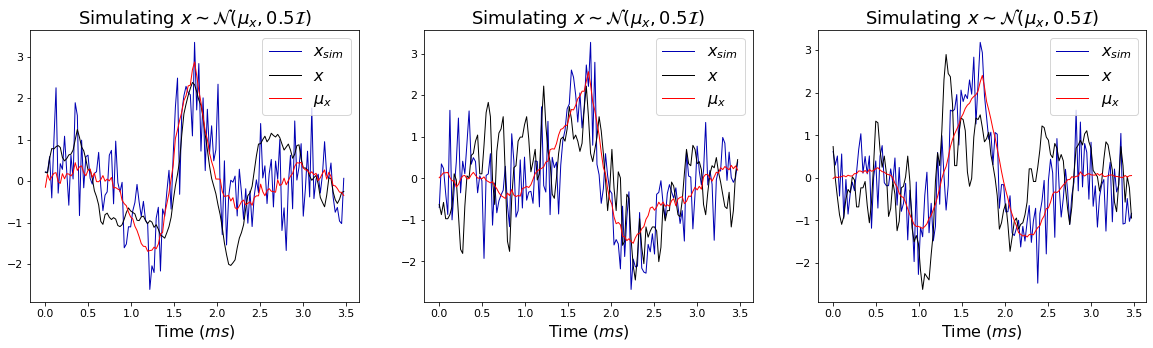

In [95]:
i=1
fig = plt.figure(figsize=(20, 5))
for jj in [10,40,80]:
    x = wf_ho[jj,:].reshape((1,141))
    label = ev_label_ho[jj,:].reshape((1,3))
    plt.subplot(1,3,i)
    plot_simulated(cvae,x,ev_label=label,n=1,var=0.5, saveas=None, verbose=False)
    i+=1
plt.show()

---
# RESULTS

<img src="../figures/jupyter/finalrun_firstR10_6_30_16_BALBC_IL1B(35ngperkg)_TNF(0_5ug)_051Main_cand_wf.png" width="700">

<img src="../figures/jupyter/finalrun_firstR10_6_30_16_BALBC_IL1B(35ngperkg)_TNF(0_5ug)_051Main_cand_ev.png" width="700">


---
# Best found results

<img src="../figures/jupyter/candidate-CAPs_TNF_Exp2_Tikz.png" width="1000">
<img src="../figures/jupyter/candidate-CAPs_TNF_Tikz.png" width="1000">
